# Basinhopping Algorithm: Combining Global Stepping with Local Minimization

### Presented by Mustafa Salman
### 14 December, 2018

# Index

1. [Defining the functions](#Defining-the-functions)
1. [Plotting the functions](#Plotting-the-functions)
1. [Closer Look at Basinhopping](#Closer-Look-at-Basinhopping)
    1. [Using different local optimization methods](#Using-different-local-optimization-methods)
    1. [Cross-validation for T & stepsize](#Cross-validation-for-T-&-stepsize)
1. [Accuracy & Efficiency](#Accuracy-&-Efficiency)
1. [Robustness](#Robustness)
1. [Discussion](#Discussion)

In [198]:
from ctf import functions2d
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import minimize, basinhopping
from matplotlib import gridspec
import warnings

warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.dpi'] = 150

cmap = plt.cm.Wistia
color1 = ((166/255,86/255,40/255,1))
color2 = ((55/255,126/255,184/255,1))
color3 = ((77/255,175/255,74/255,1))
color4 = ((152/255,78/255,163/255,1))
color5 = ((255/255,127/255,0/255,1))
color6 = ((153/255,153/255,153/255,1))
color7 = ((228/255,26/255,28/255,1))
color8 = ((247/255,129/255,191/255,1))
color9 = ((255/255,255/255,51/255,1))

tol = 1e-6

basinhopping_handicap = .5
basinhopping_early_step = 10
basinhopping_T = 1
basinhopping_stepsize = 1
basinhopping_method = 'dogleg'

# Defining the functions
([top](#Index))

The code is from https://github.com/lukemarris/ctf [3]

In [199]:
def minimize_callable(x):
    return fun.cost(x)

# functions
# Many Local Minima
functions = [
    # Many Local Minima
    ['Ackley', 1],
    ['Bukin6', 0],
    ['CrossInTray', 0],
    ['DropWave', 0],
    ['Eggholder', 0],
    ['Griewank', 0],
    ['HolderTable', 0],
    ['Levy13', 1],
    ['Rastrigin', 0],
    ['Schaffer2', 0],
    ['Schaffer4', 0],
    ['Schwefel', 0],
    # Bowl Shaped
    ['Shubert', 0],
    ['Bohachevsky1', 0],
    ['Bohachevsky2', 0],
    ['Bohachevsky3', 0],
    ['Perm', 0],
    ['RotatedHyperEllipsoid', 0],
    ['Sphere', 1],
    ['SumOfDifferentPowers', 0],
    ['SumSquares', 0],
    # Plate-Shaped
    ['Trid', 0],
    ['Booth', 1],
    ['Matyas', 1],
    ['McCormick', 1],
    ['PowerSum', 0],
    # Valley-Shaped
    ['Zakharov', 0],
    ['ThreeHumpCamel', 1],
    ['SixHumpCamel', 0],
    ['DixonPrice', 0],
    ['Rosenbrock', 1],
    # Steep Ridges/Drops
    ['Absolute', 1],
    ['AbsoluteSkewed', 1],
    ['DeJong5', 0],
    ['Easom', 1],
    ['Michalewicz', 0],
    ['Beale', 1],
    ['Branin', 0],
    ['GoldsteinPrice', 1],
    ['StyblinskiTang', 1]]

functions = [
    ['Ackley', 1],
    ['Sphere', 1],
    ['Booth', 1],
    ['ThreeHumpCamel', 1],
    ['Rosenbrock', 1],
    ['Beale', 1]]

#fun = functions2d.Rosenbrock()

def cost_callable(x):
    return fun.cost(x)

def jac_callable(x):
    return fun.grad(x)

def hess_callable(x):
    return fun.hess(x)

def log_callback(*args):
    global err, fun, xk, accept
    xk.append( args[0] )
    err = np.append( err, np.linalg.norm(args[0]-fun.min) )

# Plotting the functions
([top](#Index))

Below we plot the contours of different 2D functions used in the project.

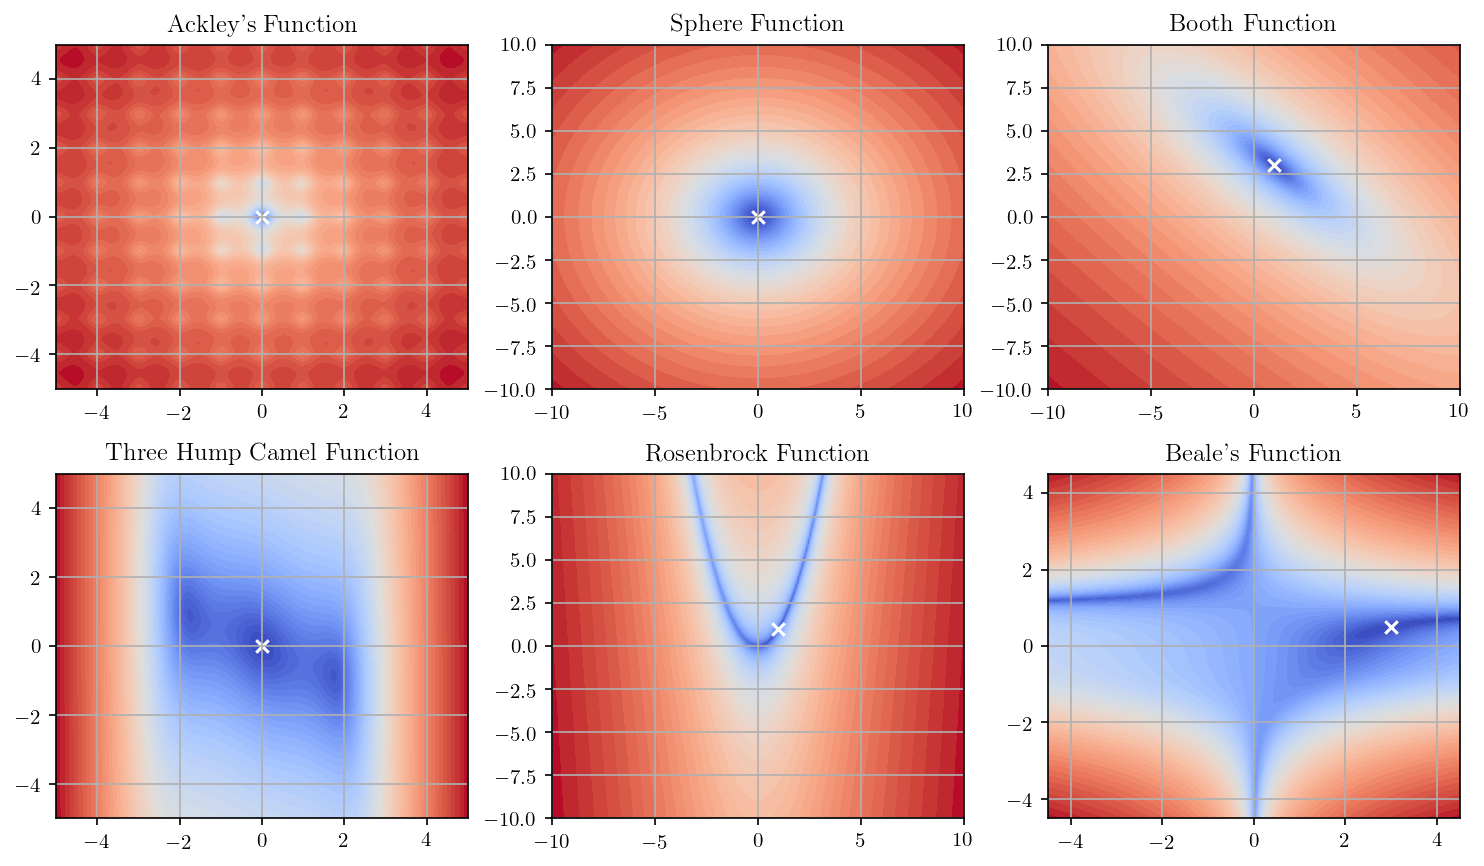

In [200]:
rows = 14
cols = 3
fig = plt.figure(figsize=(10, 40))
gs = gridspec.GridSpec(rows, cols)

row = 0
col = 0
for i in range( len(functions) ):
    target_fun = getattr(functions2d, functions[i][0])
    fun = target_fun()
    
    """ Plots the cost contour plot over the domain of the function. """
    ax = fig.add_subplot(gs[row, col])
    # Latex
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    
    ## Domain Correction
    # Lower x0 Limit
    if np.isfinite(fun.domain[0][0]):
        x0_lim_lower = fun.domain[0][0]
    else:
        x0_lim_lower = -10.0
    # Upper x0 Limit
    if np.isfinite(fun.domain[0][1]):
        x0_lim_upper = fun.domain[0][1]
    else:
        x0_lim_upper = +10.0
    # Lower x1 Limit
    if np.isfinite(fun.domain[1][0]):
        x1_lim_lower = fun.domain[1][0]
    else:
        x1_lim_lower = -10.0
    # Upper x1 Limit
    if np.isfinite(fun.domain[1][1]):
        x1_lim_upper = fun.domain[1][1]
    else:
        x1_lim_upper = +10.0
    
    ## Lines
    points = 200
    x0 = np.linspace(x0_lim_lower, x0_lim_upper, points)
    x1 = np.linspace(x1_lim_lower, x1_lim_upper, points)
    ## Meshes
    X0, X1 = np.meshgrid(x0, x1)
    ## Combined
    X = np.array([X0, X1])
    
    ## Calculate Costs
    cost = fun.cost(X)
    ## Renormalise
    cost_norm = np.log(cost - np.min(cost) + 1)
    
    ## Plot
    ax.contourf(X0, X1, cost_norm, 50, cmap=plt.cm.coolwarm)
    plt.scatter(fun.min[..., 0], fun.min[..., 1], c='w', marker='x')
    plt.grid()
#     plt.title(fun.latex_name + "\n" + fun.latex_cost)
    plt.title(fun.latex_name)
    plt.subplots_adjust(top=0.8)
    plt.xlim([x0_lim_lower, x0_lim_upper])
    plt.ylim([x1_lim_lower, x1_lim_upper])
        
    col = np.mod(col+1, cols)
    if col == 0:
        row = np.mod(row+1, rows)

plt.tight_layout()
plt.show()

# Closer Look at Basinhopping
([top](#Index))

Basin-hopping is a stochastic algorithm which attempts to find the global minimum of a smooth scalar function of one or more variables [1].

### Heuristics

1. random perturbation of the coordinates
1. local minimization
1. accept or reject the new coordinates based on the minimized function value

### Algorithm [2]

1. $i \leftarrow 0$
1. $X_i \leftarrow \text{random initial point in variable space}$
1. $Y_i \leftarrow \texttt{LOCALSEARCH}(X_i)$
1. $\mathbf{while} \ \texttt{STOP} \ \text{not satisfied} \ \mathbf{do:}$
1. $\quad X_{i+1} \leftarrow \ \texttt{PURTURB}(Y_i)$
1. $\quad Y_{i+1} \leftarrow \ \texttt{LOCALSEARCH}(X_{i+1})$
1. $\quad \mathbf{if} \ f(Y_{i+1}) < f(Y_i) \ \mathbf{then}$
1. $\quad \quad i \leftarrow i+1$

### SciPy implementation [3]

* `LOCALSEARCH` uses `BFGS` by default. Using the `minimizer_kwargs` parameter, it is possible to use any `scipy.optimize.minimize` method and specify the gradient/hessian as needed or even a custom *do nothing* function which may implement simulated annealing.
* A callback is implemented for each minima found.
* `PURTURB` uniformly samples a new $X_{i+1}$ from $[X_{i}-\text{stepsize}, X_{i}+\text{stepsize}]$ in each dimension. `stepsize` is adjusted automatically by the basinhopping algorithm, also can be passed as a parameter. A `take_step` callback is implemented, which can replace the default step-taking routine.
* The acceptance test uses the Metropolis criterion of standard Monte Carlo algorithm. Steps are always accepted if $f(X_{i+1}) < f(X_i)$. Otherwise, they are accepted with probability 
$$exp( -\frac{f(X_{i+1}) - f(X_i)}{T} )$$
Where $T$ is the temperature used in the Metropolis criterion. If $T=0$, then all steps that increase the function value are rejected. An `accept_test` callback is also implemented for defining custom acceptance test.
* An optional `interval` parameter is available which determines how often `stepsize` is updated, and also a `niter_success` which stops the run if global minimum candidate remains the same for this number of iterations.

## Using different local optimization methods
([top](#Index))

x0= [ 0.14702867 -4.08541437]
Rosenbrock Function : global min= [ 1.  1.]
basinhopping:  ['success condition satisfied'] x= [ 1.  1.]


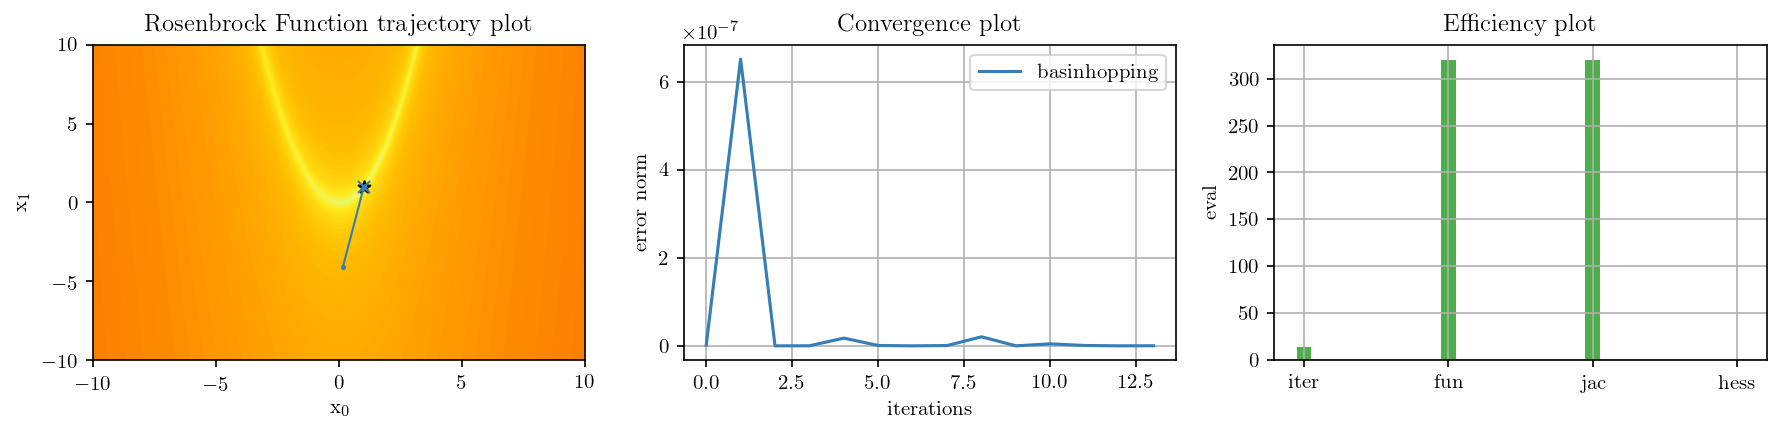

In [239]:
x0_lim_lower = -10.0
x0_lim_upper = +10.0
x1_lim_lower = -10.0
x1_lim_upper = +10.0
x0 = np.array([np.random.uniform(x0_lim_lower, x0_lim_upper, 1)[0],
               np.random.uniform(x1_lim_lower, x1_lim_upper, 1)[0]])
print('x0=', x0)

target_fun = getattr(functions2d, 'Rosenbrock')
fun = target_fun()
print(fun.latex_name,': global min=', fun.min)

fig = plt.figure(figsize=(12, 3))
gs = gridspec.GridSpec(1, 3)

# algorithm x evals
ev = np.zeros((1,4))
alg = 0

# run optimization
xk = [x0]
err = np.array([])
accept = np.array([])
res = basinhopping(cost_callable, x0, callback=log_callback, niter_success=10, #stepsize=1, T=.1,
                   minimizer_kwargs={'method': 'BFGS', 'jac': jac_callable, 
                                     'hess': hess_callable, 'tol': tol})
print('basinhopping: ', res.message, 'x=', res.x)
basinhopping_err= np.copy(err)
basinhopping_xk = np.copy(xk)
ev[alg,0] = res.nit
ev[alg,1] = res.nfev
ev[alg,2] = res.njev
ev[alg,3] = 1
alg += 1

# tragectory plot
ax2 = fig.add_subplot(gs[0, 0])
## Lines
points = 200
x00 = np.linspace(x0_lim_lower, x0_lim_upper, points)
x11 = np.linspace(x1_lim_lower, x1_lim_upper, points)
## Meshes
X0, X1 = np.meshgrid(x00, x11)
## Combined
X = np.array([X0, X1])

## Calculate Costs
cost = fun.cost(X)
## Renormalise
cost_norm = np.log(cost - np.min(cost) + 1)

## Plot
ax2.contourf(X0, X1, cost_norm, 50, cmap=cmap)
plt.scatter(fun.min[..., 0], fun.min[..., 1], c='k', marker='*')

plt.plot(basinhopping_xk[:,0], basinhopping_xk[:,1], '.-', markersize=3, linewidth=1, color=color2)
plt.plot(basinhopping_xk[-1,0], basinhopping_xk[-1,1], 'x', color=color2)

#     plt.grid()
#     plt.title(fun.latex_name + "\n" + fun.latex_cost)
plt.title(fun.latex_name+' trajectory plot')
plt.subplots_adjust(top=0.8)
plt.xlim([x0_lim_lower, x0_lim_upper])
plt.ylim([x1_lim_lower, x1_lim_upper])
plt.xlabel('x_0')
plt.ylabel('x_1')

# convergence plot
ax1 = fig.add_subplot(gs[0, 1])
plt.plot(basinhopping_err, color=color2)
plt.title('Convergence plot')
plt.xlabel('iterations')
plt.ylabel('error norm')
plt.subplots_adjust(top=0.8)
plt.grid()
plt.legend(['basinhopping'])

# efficiency
ax3 = fig.add_subplot(gs[0, 2])
x = np.arange(4)*2
#     ev = np.log10(ev)
ax3.bar(x, ev[0,:], color=color3, width=.2)
plt.xticks(x, ['iter', 'fun', 'jac', 'hess'])
plt.title('Efficiency plot')
plt.ylabel('#eval')
plt.subplots_adjust(top=0.8)
plt.grid()

plt.tight_layout()
plt.show()



## Cross-validation for `T` & `stepsize`
([top](#Index))

Rosenbrock Function : global min= [ 1.  1.]


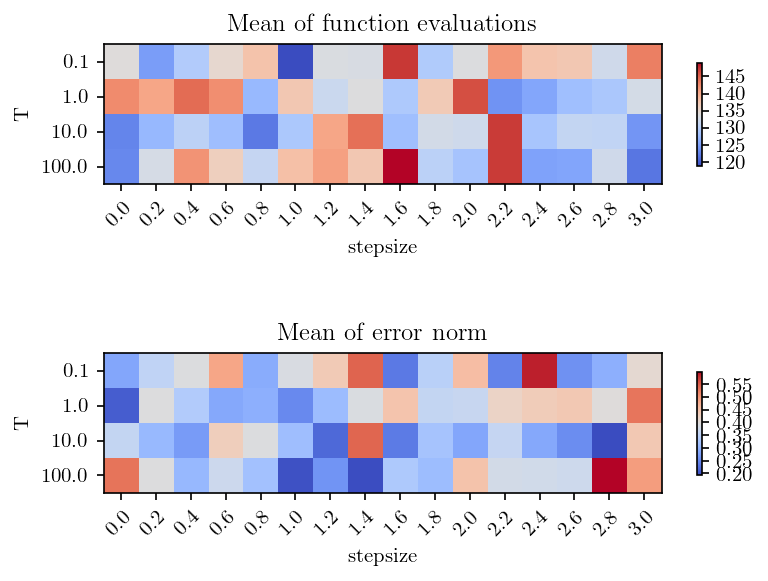

In [209]:
T = np.logspace(-1, 2, 4)
stepsize = np.linspace(0, 3, 16)
repeats = 50

target_fun = getattr(functions2d, 'Rosenbrock')
fun = target_fun()
print(fun.latex_name,': global min=', fun.min)

# measure x T x stepsize
ev = np.zeros((5, T.shape[0], stepsize.shape[0], repeats))

for i in range(len(T)):
    for j in range(len(stepsize)):
        for k in range(repeats):
            # run optimization
            x0_lim_lower = -10.0
            x0_lim_upper = +10.0
            x1_lim_lower = -10.0
            x1_lim_upper = +10.0
            x0 = np.array([np.random.uniform(x0_lim_lower, x0_lim_upper, 1)[0],
                           np.random.uniform(x1_lim_lower, x1_lim_upper, 1)[0]])
#             print('x0=', x0)

            xk = [x0]
            err = np.array([])
            accept = np.array([])
            res = basinhopping(cost_callable, x0, callback=log_callback, niter_success=10, #stepsize=1, T=.1,
                               minimizer_kwargs={'method': basinhopping_method, 'jac': jac_callable, 
                                                 'hess': hess_callable, 'tol': tol})
    #         print('basinhopping: ', res.message, 'x=', res.x)
            ev[0,i,j,k] = res.nit
            ev[1,i,j,k] = res.nfev
            ev[2,i,j,k] = res.njev
            ev[3,i,j,k] = 1
            ev[4,i,j,k] = np.mean(err)

ev = np.mean(ev, axis=3)

fig = plt.figure(figsize=(6, 5))
gs = gridspec.GridSpec(2,1)

ax = fig.add_subplot(gs[0])
im = ax.imshow( ev[1,:,:], cmap='coolwarm' )

ax.set_xticks(np.arange( len(stepsize) ))
ax.set_yticks(np.arange( len(T) ))
ax.set_xticklabels(stepsize)
ax.set_yticklabels(T)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel('stepsize')
plt.ylabel('T')
cb = plt.colorbar(im)

l, b, w, h = ax.get_position().bounds
ll, bb, ww, hh = cb.ax.get_position().bounds
cb.ax.set_position([ll, b + 0.3*h, ww, h*0.4])

# for i in range(len(num_of_points)):
#     for j in range(len(C)):
#         text = ax.text(i, j, round(results_7[j, i], 4), ha="center", va="center", color="k", size=4)

ax.set_title("Mean of function evaluations")

ax2 = fig.add_subplot(gs[1])
im = ax2.imshow( ev[4,:,:], cmap='coolwarm' )

ax2.set_xticks(np.arange( len(stepsize) ))
ax2.set_yticks(np.arange( len(T) ))
ax2.set_xticklabels(stepsize)
ax2.set_yticklabels(T)

plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel('stepsize')
plt.ylabel('T')
cb = plt.colorbar(im)

l, b, w, h = ax2.get_position().bounds
ll, bb, ww, hh = cb.ax.get_position().bounds
cb.ax.set_position([ll, b + 0.3*h, ww, h*0.4])

# for i in range(len(num_of_points)):
#     for j in range(len(C)):
#         text = ax.text(i, j, round(results_7[j, i], 4), ha="center", va="center", color="k", size=4)

ax2.set_title("Mean of error norm")

plt.show()

## Accuracy & Efficiency
([top](#Index))

x0= [-7.76876661 -3.63665882]
Ackley's Function : global min= [ 0.  0.]
CG:  Desired error not necessarily achieved due to precision loss. x= [-7.98820012 -3.99220556]
BFGS:  Optimization terminated successfully. x= [-7.98661831 -3.99331506]
Newton_CG:  Optimization terminated successfully. x= [-7.98661831 -3.99331506]
dogleg:  A linalg error occurred, such as a non-psd Hessian. x= [-7.76876661 -3.63665882]
trust-ncg:  Optimization terminated successfully. x= [-7.98661831 -3.99331506]
basinhopping:  ['success condition satisfied'] x= [-5.98157064 -2.99080073]


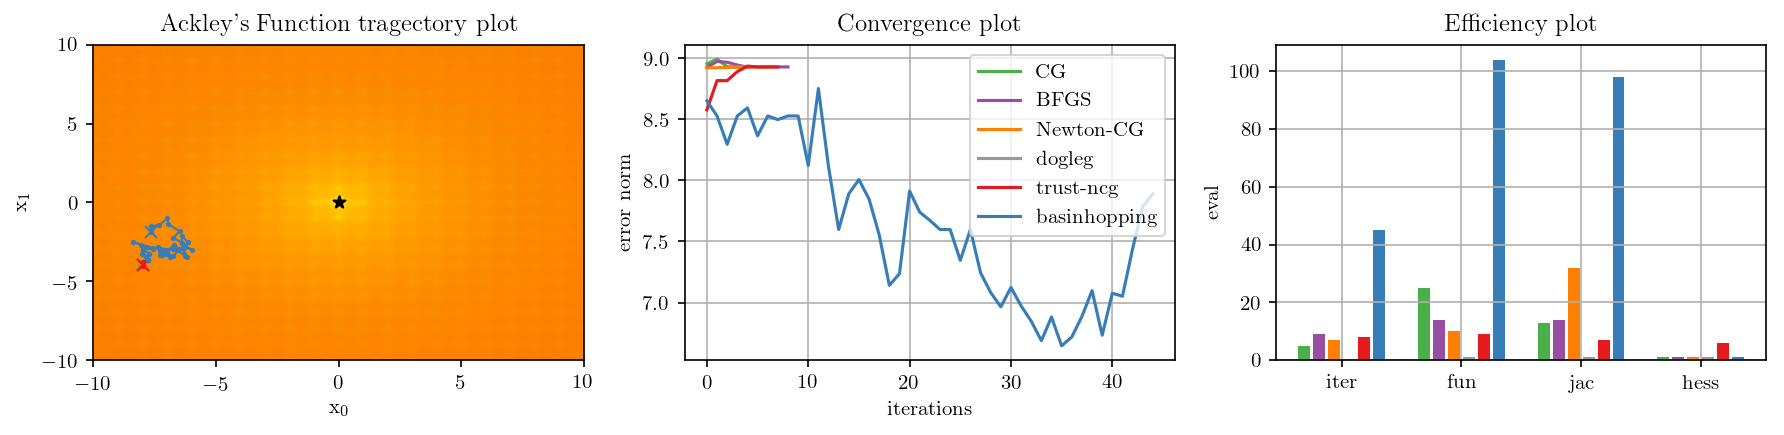

Sphere Function : global min= [ 0.  0.]
CG:  Desired error not necessarily achieved due to precision loss. x= [ 0.82976509  0.38842363]
BFGS:  Optimization terminated successfully. x= [ -1.38777878e-16   2.35922393e-16]
Newton_CG:  Optimization terminated successfully. x= [ -3.91224386e-09  -1.83137150e-09]
dogleg:  Optimization terminated successfully. x= [ -2.22044605e-16  -1.11022302e-16]
trust-ncg:  Optimization terminated successfully. x= [ 0.  0.]
basinhopping:  ['success condition satisfied'] x= [ 0.  0.]


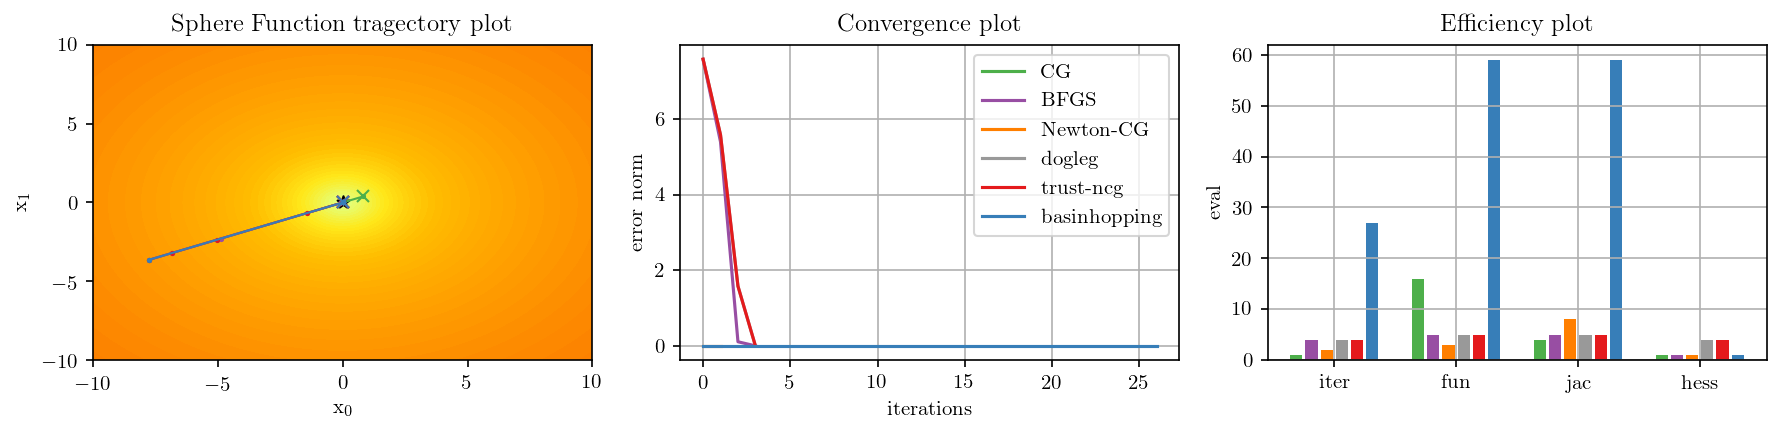

Booth Function : global min= [ 1.  3.]
CG:  Optimization terminated successfully. x= [ 1.  3.]
BFGS:  Optimization terminated successfully. x= [ 1.  3.]
Newton_CG:  Optimization terminated successfully. x= [ 1.          2.99999999]
dogleg:  Optimization terminated successfully. x= [ 1.  3.]
trust-ncg:  Optimization terminated successfully. x= [ 1.  3.]
basinhopping:  ['success condition satisfied'] x= [ 1.  3.]


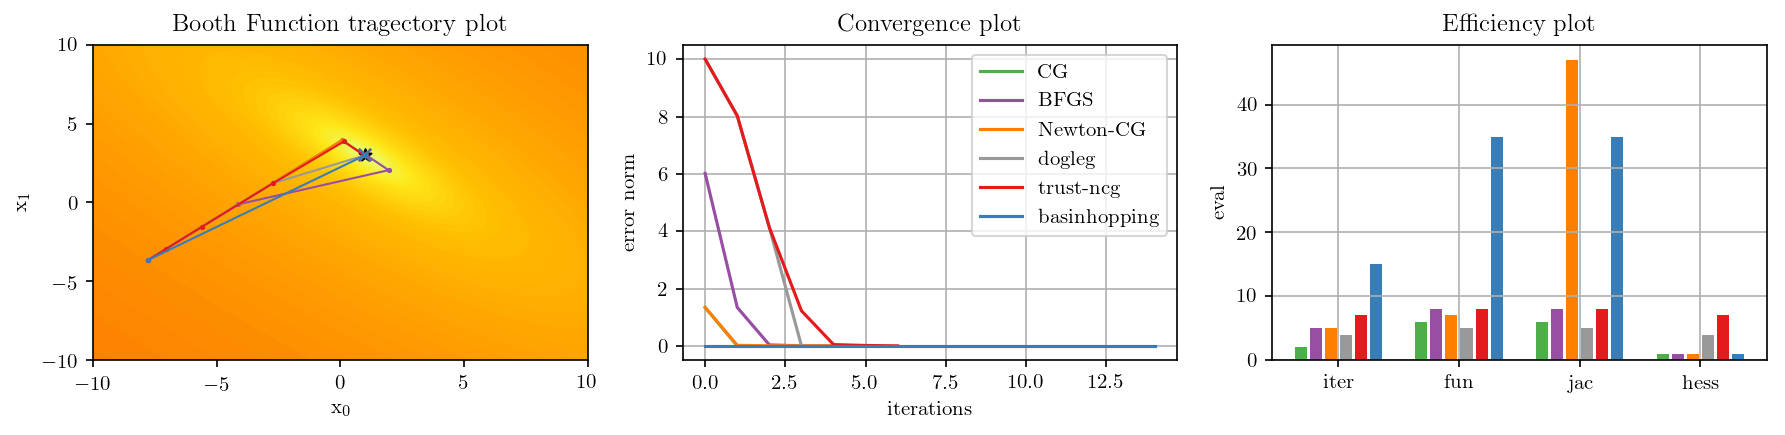

Three Hump Camel Function : global min= [ 0.  0.]
CG:  Optimization terminated successfully. x= [ 1.74755234 -0.87377616]
BFGS:  Optimization terminated successfully. x= [-1.74755233  0.87377634]
Newton_CG:  Optimization terminated successfully. x= [-1.74755234  0.87377617]
dogleg:  Optimization terminated successfully. x= [-1.74755242  0.87377621]
trust-ncg:  Optimization terminated successfully. x= [-1.74755237  0.87377619]
basinhopping:  ['success condition satisfied'] x= [-1.74755235  0.87377617]


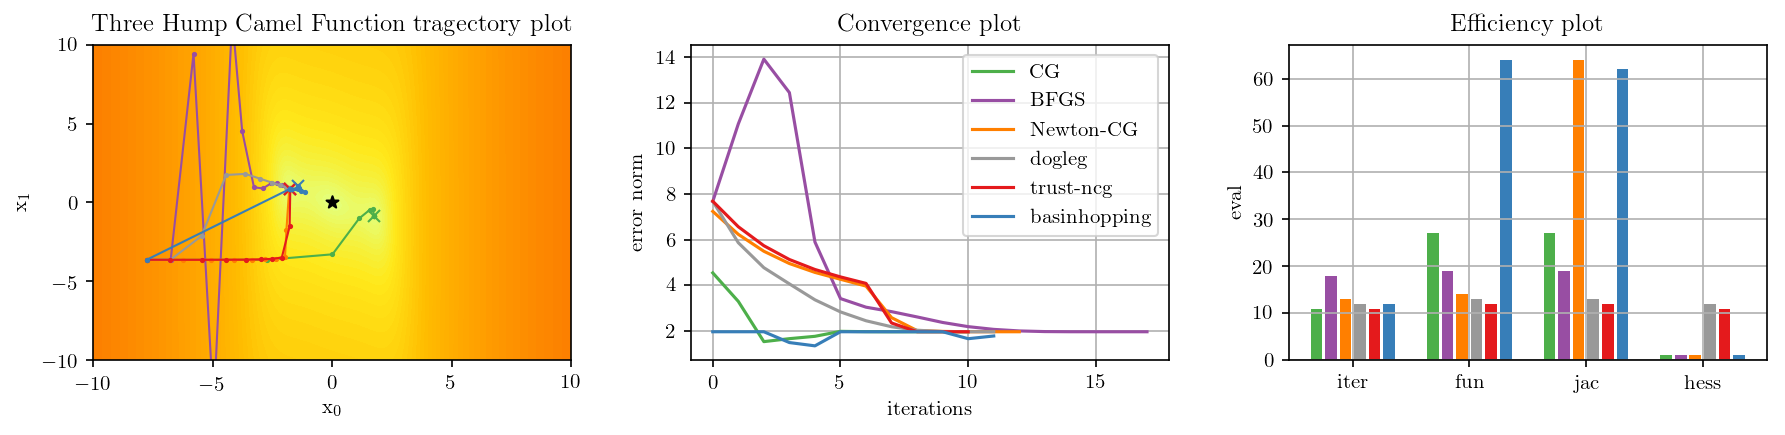

Rosenbrock Function : global min= [ 1.  1.]
CG:  Optimization terminated successfully. x= [ 1.  1.]
BFGS:  Optimization terminated successfully. x= [ 1.  1.]
Newton_CG:  Optimization terminated successfully. x= [ 0.99999807  0.99999614]
dogleg:  Optimization terminated successfully. x= [ 0.99999993  0.99999985]
trust-ncg:  Optimization terminated successfully. x= [ 1.  1.]
basinhopping:  ['success condition satisfied'] x= [ 1.  1.]


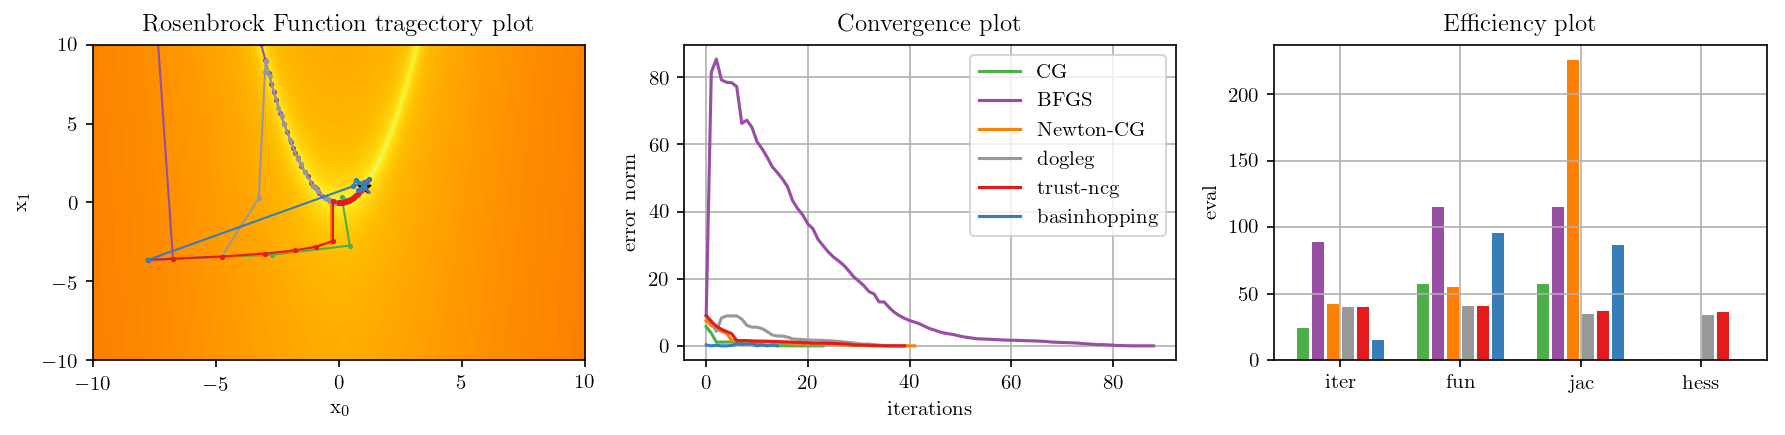

Beale's Function : global min= [ 3.   0.5]
CG:  Desired error not necessarily achieved due to precision loss. x= [-662.68623212    1.00149353]
BFGS:  Maximum number of iterations has been exceeded. x= [ -1.23953123e+04   1.00007994e+00]
Newton_CG:  Warning: CG iterations didn't converge.  The Hessian is not positive definite. x= [-55.20452143   1.0176702 ]
dogleg:  A linalg error occurred, such as a non-psd Hessian. x= [-7.76876661 -3.63665882]
trust-ncg:  A bad approximation caused failure to predict improvement. x= [-657.22645875    1.00150592]
basinhopping:  ['success condition satisfied'] x= [-6.76477861  1.13622064]


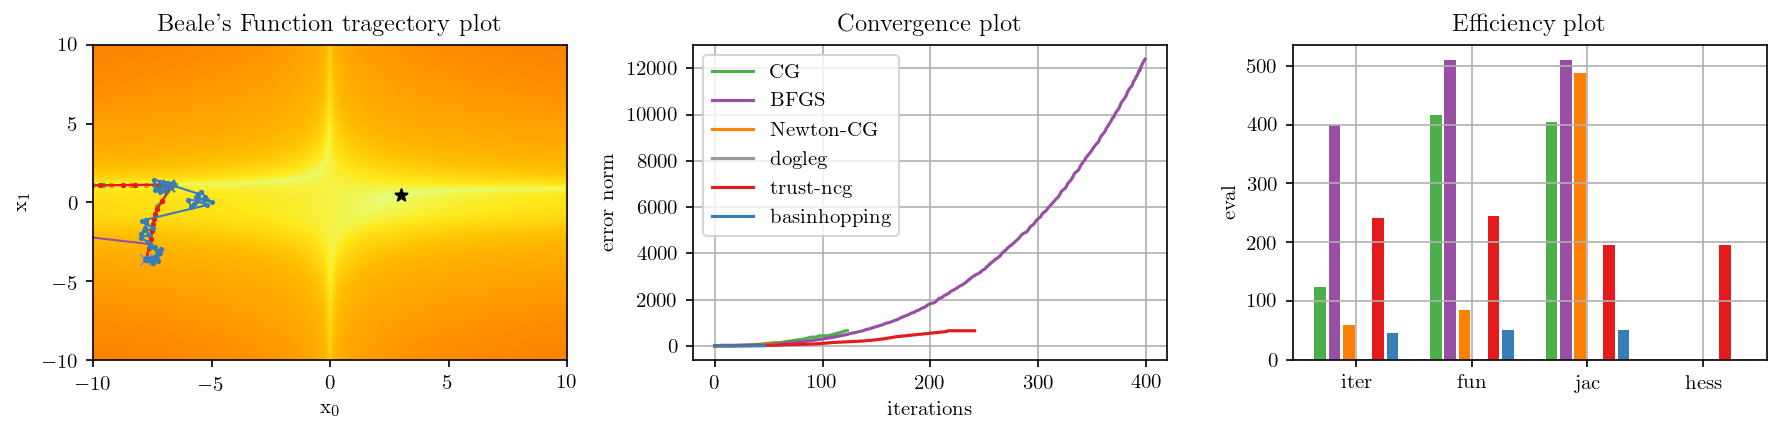

In [203]:
# some bad/interesting init
# x0= [ 0.25383641 -9.32127049] # everybody fails
# x0= [-0.02711468  3.70806972] # everybody fails
# x0= [-3.35433242  2.63687587] # bfgs beale blowup

x0_lim_lower = -10.0
x0_lim_upper = +10.0
x1_lim_lower = -10.0
x1_lim_upper = +10.0
x0 = np.array([np.random.uniform(x0_lim_lower, x0_lim_upper, 1)[0],
               np.random.uniform(x1_lim_lower, x1_lim_upper, 1)[0]])
print('x0=', x0)

for i in range( len(functions) ):
    if not functions[i][1]:
        continue
        
    target_fun = getattr(functions2d, functions[i][0])
    fun = target_fun()
    print(fun.latex_name,': global min=', fun.min)
    
    fig = plt.figure(figsize=(12, 3))
    gs = gridspec.GridSpec(1, 3)
    
    # algorithm x evals
    ev = np.zeros((6,4))
    alg = 0
    
    # run optimization
    xk = [x0]
    err = np.array([])
    res = minimize(cost_callable, x0, method='CG', tol=tol, 
                   jac=jac_callable, callback=log_callback)
    print('CG: ', res.message, 'x=', res.x)
    CG_err = np.copy(err)
    CG_xk = np.copy(xk)
    ev[alg,0] = res.nit
    ev[alg,1] = res.nfev
    ev[alg,2] = res.njev
    ev[alg,3] = 1
    alg += 1

    xk = [x0]
    err = np.array([])
    res = minimize(cost_callable, x0, method='BFGS', tol=tol, 
                   jac=jac_callable, callback=log_callback)
    print('BFGS: ', res.message, 'x=', res.x)
    BFGS_err = np.copy(err)
    BFGS_xk = np.copy(xk)
    ev[alg,0] = res.nit
    ev[alg,1] = res.nfev
    ev[alg,2] = res.njev
    ev[alg,3] = 1
    alg += 1

    xk = [x0]
    err = np.array([])
    res = minimize(cost_callable, x0, method='Newton-CG', tol=tol, 
                   jac=jac_callable, callback=log_callback)
    print('Newton_CG: ', res.message, 'x=', res.x)
    Newton_CG_err = np.copy(err)
    Newton_CG_xk = np.copy(xk)
    ev[alg,0] = res.nit
    ev[alg,1] = res.nfev
    ev[alg,2] = res.njev
    ev[alg,3] = 1
    alg += 1

    xk = [x0]
    err = np.array([])
    res = minimize(cost_callable, x0, method='dogleg', tol=tol, 
                   jac=jac_callable, hess=hess_callable, callback=log_callback)
    print('dogleg: ', res.message, 'x=', res.x)
    dogleg_err = np.copy(err)
    dogleg_xk = np.copy(xk)
    ev[alg,0] = res.nit
    ev[alg,1] = res.nfev
    ev[alg,2] = res.njev
    ev[alg,3] = res.nhev
    alg += 1

    xk = [x0]
    err = np.array([])
    res = minimize(cost_callable, x0, method='trust-ncg', tol=tol, 
                   jac=jac_callable, hess=hess_callable, callback=log_callback)
    print('trust-ncg: ', res.message, 'x=', res.x)
    trust_ncg_err = np.copy(err)
    trust_ncg_xk = np.copy(xk)
    ev[alg,0] = res.nit
    ev[alg,1] = res.nfev
    ev[alg,2] = res.njev
    ev[alg,3] = res.nhev
    alg += 1

    xk = [x0]
    err = np.array([])
    accept = np.array([])
    res = basinhopping(cost_callable, x0, callback=log_callback, niter_success=10,
                       minimizer_kwargs={'method': basinhopping_method, 'jac': jac_callable, 
                                         'hess': hess_callable, 'tol': tol})
    print('basinhopping: ', res.message, 'x=', res.x)
    basinhopping_err= np.copy(err)
    basinhopping_xk = np.copy(xk)
    ev[alg,0] = res.nit
    ev[alg,1] = res.nfev
    ev[alg,2] = res.njev
    ev[alg,3] = 1
    alg += 1
    
    # tragectory plot
    ax2 = fig.add_subplot(gs[0, 0])
    ## Lines
    points = 200
    x00 = np.linspace(x0_lim_lower, x0_lim_upper, points)
    x11 = np.linspace(x1_lim_lower, x1_lim_upper, points)
    ## Meshes
    X0, X1 = np.meshgrid(x00, x11)
    ## Combined
    X = np.array([X0, X1])
    
    ## Calculate Costs
    cost = fun.cost(X)
    ## Renormalise
    cost_norm = np.log(cost - np.min(cost) + 1)
    
    ## Plot
    ax2.contourf(X0, X1, cost_norm, 50, cmap=cmap)
    plt.scatter(fun.min[..., 0], fun.min[..., 1], c='k', marker='*')
    
    plt.plot(CG_xk[:,0], CG_xk[:,1], '.-', markersize=3, linewidth=1, color=color3)
    plt.plot(CG_xk[-1,0], CG_xk[-1,1], 'x', color=color3)

    plt.plot(BFGS_xk[:,0], BFGS_xk[:,1], '.-', markersize=3, linewidth=1, color=color4)
    plt.plot(BFGS_xk[-1,0], BFGS_xk[-1,1], 'x', color=color4)

    plt.plot(Newton_CG_xk[:,0], Newton_CG_xk[:,1], '.-', markersize=3, linewidth=1, color=color5)
    plt.plot(Newton_CG_xk[-1,0], Newton_CG_xk[-1,1], 'x', color=color5)

    plt.plot(dogleg_xk[:,0], dogleg_xk[:,1], '.-', markersize=3, linewidth=1, color=color6)
    plt.plot(dogleg_xk[-1,0], dogleg_xk[-1,1], 'x', color=color6)

    plt.plot(trust_ncg_xk[:,0], trust_ncg_xk[:,1], '.-', markersize=3, linewidth=1, color=color7)
    plt.plot(trust_ncg_xk[-1,0], trust_ncg_xk[-1,1], 'x', color=color7)

    plt.plot(basinhopping_xk[:,0], basinhopping_xk[:,1], '.-', markersize=3, linewidth=1, color=color2)
    plt.plot(basinhopping_xk[-1,0], basinhopping_xk[-1,1], 'x', color=color2)

#     plt.grid()
#     plt.title(fun.latex_name + "\n" + fun.latex_cost)
    plt.title(fun.latex_name+' tragectory plot')
    plt.subplots_adjust(top=0.8)
    plt.xlim([x0_lim_lower, x0_lim_upper])
    plt.ylim([x1_lim_lower, x1_lim_upper])
    plt.xlabel('x_0')
    plt.ylabel('x_1')
    
    # convergence plot
    ax1 = fig.add_subplot(gs[0, 1])
    plt.plot(CG_err, color=color3)
    plt.plot(BFGS_err, color=color4)
    plt.plot(Newton_CG_err, color=color5)
    plt.plot(dogleg_err, color=color6)
    plt.plot(trust_ncg_err, color=color7)
    plt.plot(basinhopping_err, color=color2)
    plt.title('Convergence plot')
    plt.xlabel('iterations')
    plt.ylabel('error norm')
    plt.subplots_adjust(top=0.8)
    plt.grid()
    plt.legend(['CG', 'BFGS', 'Newton-CG', 'dogleg', 'trust-ncg', 'basinhopping'])
    
    # efficiency
    ax3 = fig.add_subplot(gs[0, 2])
    x = np.arange(4)*2
#     ev = np.log10(ev)
    ax3.bar(x, ev[0,:], color=color3, width=.2)
    ax3.bar(x+.25, ev[1,:], color=color4, width=.2)
    ax3.bar(x+.5, ev[2,:], color=color5, width=.2)
    ax3.bar(x+.75, ev[3,:], color=color6, width=.2)
    ax3.bar(x+1, ev[4,:], color=color7, width=.2)
    ax3.bar(x+1.25, ev[5,:], color=color2, width=.2)
    plt.xticks(x+.625, ['iter', 'fun', 'jac', 'hess'])
    plt.title('Efficiency plot')
    plt.ylabel('#eval')
    plt.subplots_adjust(top=0.8)
    plt.grid()
    
    plt.tight_layout()
    plt.show()
    
    

## Robustness
([top](#Index))

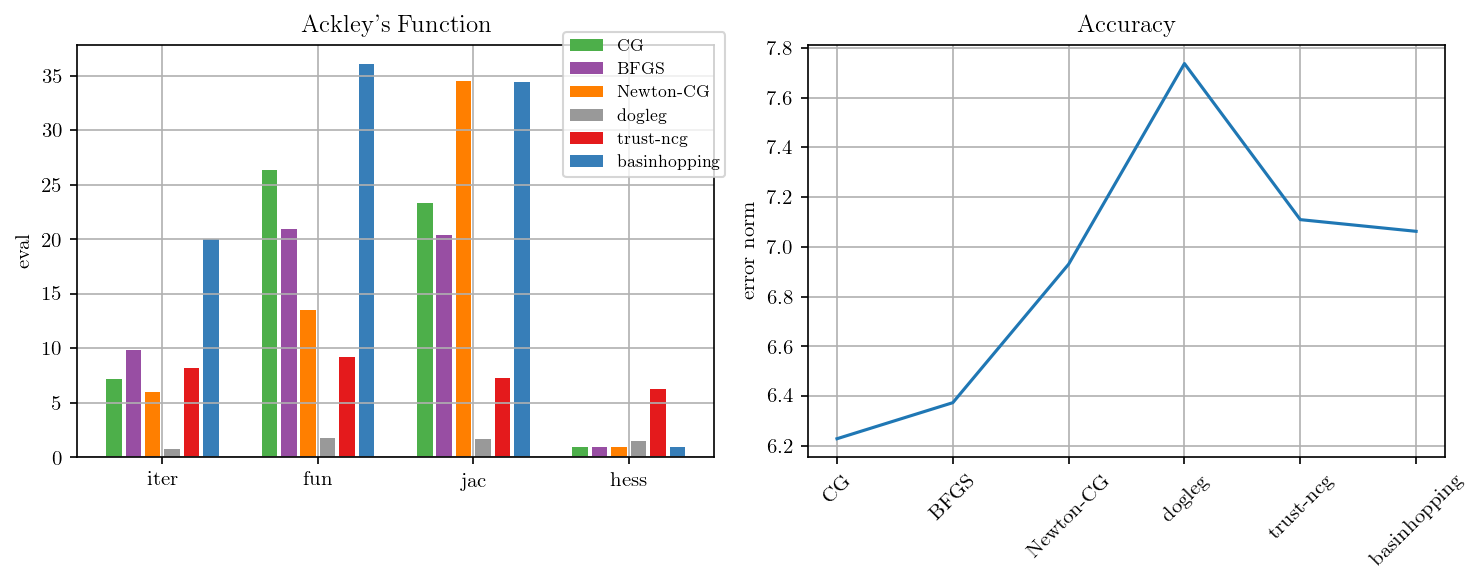

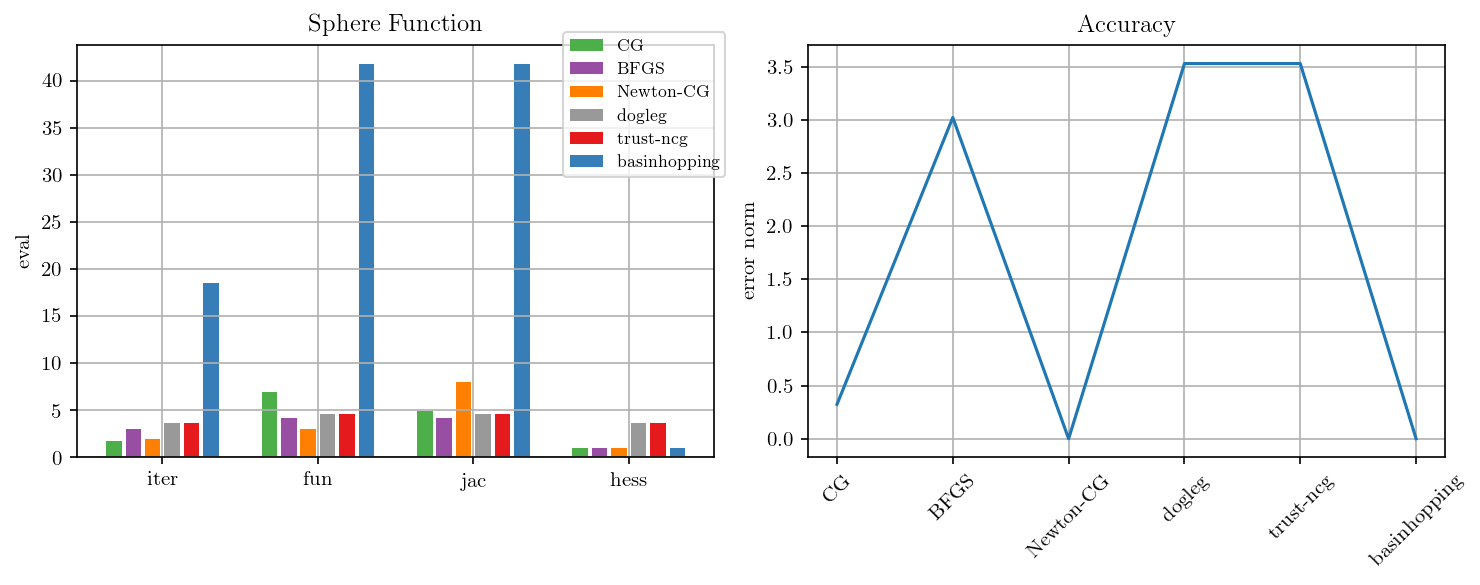

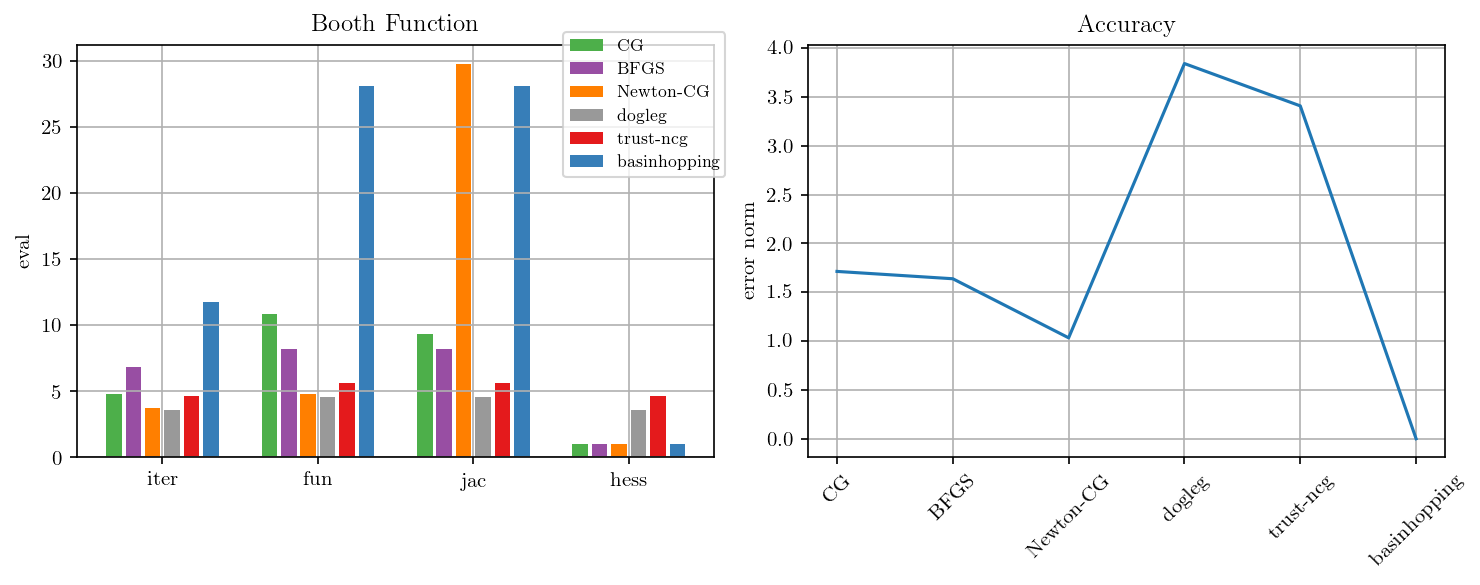

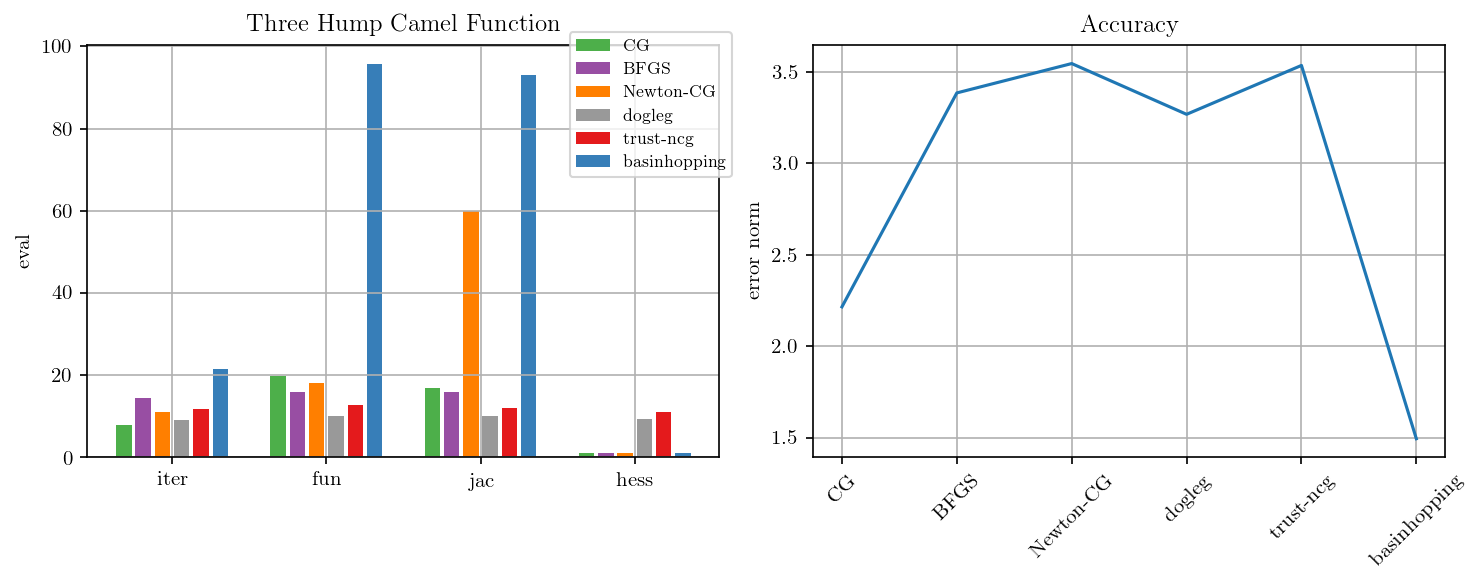

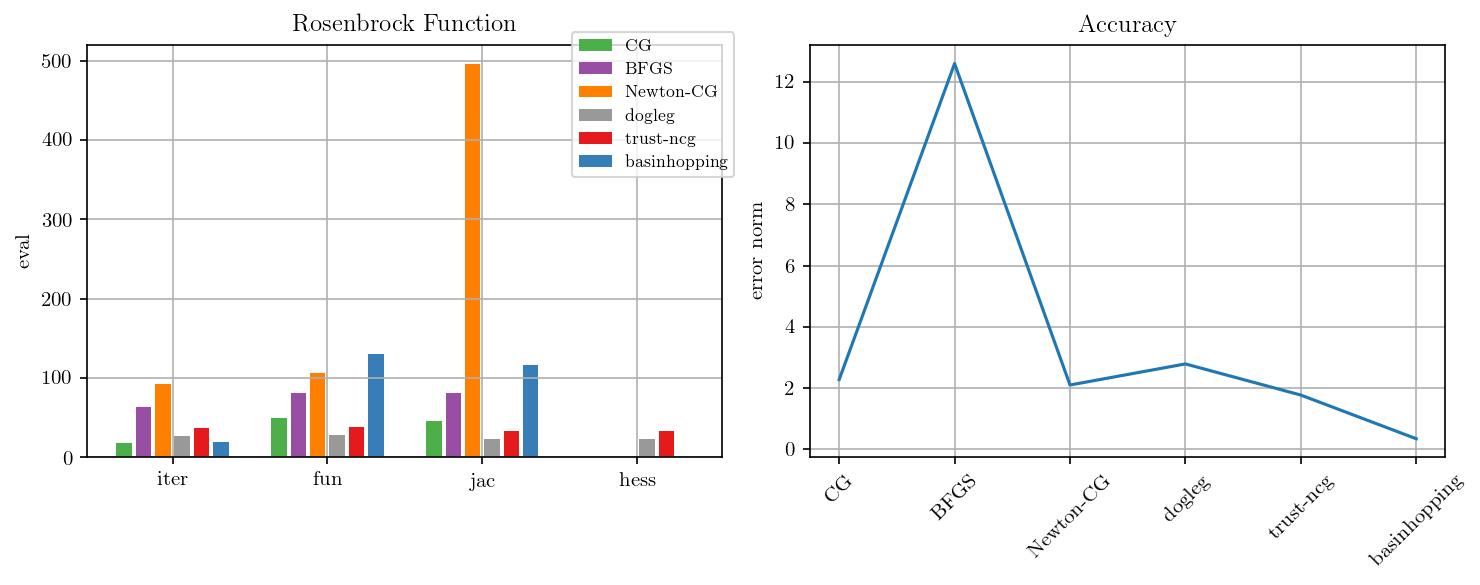

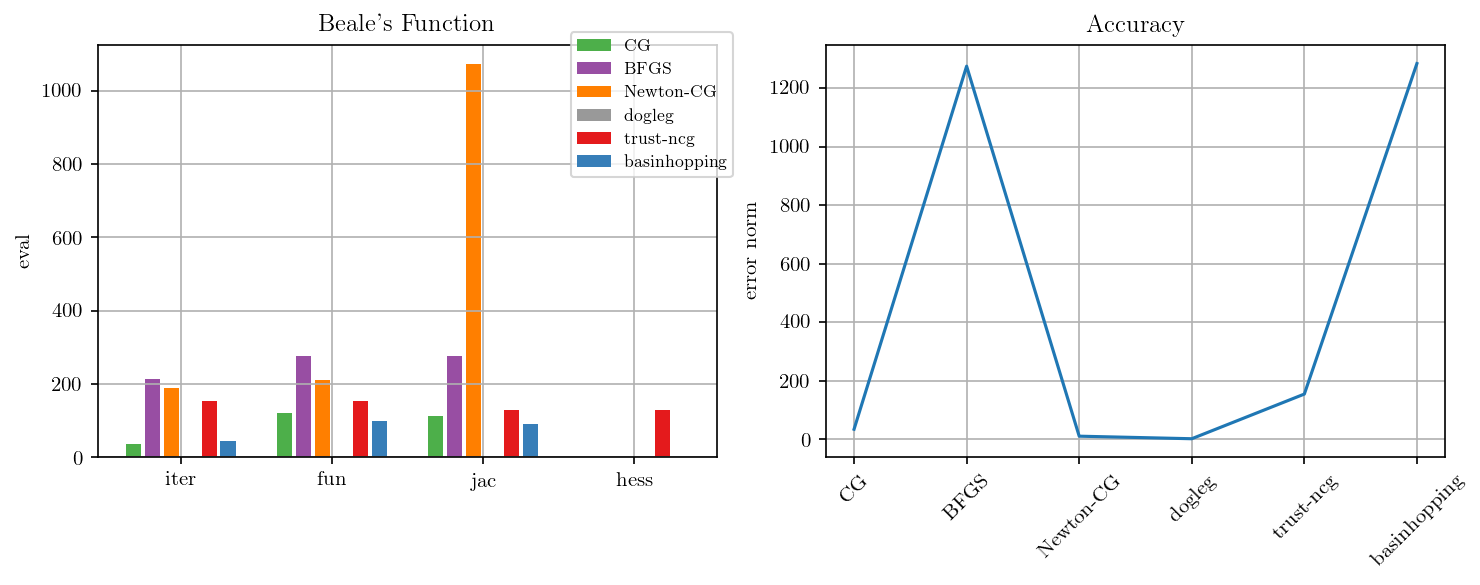

In [204]:
repeats = 100
algorithms = 6
measures = 5
# functions_robust = [
# #         ['Ackley', 1]
# #         ['Booth', 1]
#         ['Beale', 1]
#     ]
functions_robust = functions

ev = np.zeros((algorithms, measures, len(functions_robust), repeats))
for j in range(repeats):
    for i in range( len(functions_robust) ):
        if not functions_robust[i][1]:
            continue
        
        target_fun = getattr(functions2d, functions_robust[i][0])
        fun = target_fun()
        
        # algorithm x evals
        alg = 0

#         ## Domain Correction
#         # Lower x0 Limit
#         if np.isfinite(fun.domain[0][0]):
#             x0_lim_lower = fun.domain[0][0]
#         else:
#             x0_lim_lower = -10.0
#         # Upper x0 Limit
#         if np.isfinite(fun.domain[0][1]):
#             x0_lim_upper = fun.domain[0][1]
#         else:
#             x0_lim_upper = +10.0
#         # Lower x1 Limit
#         if np.isfinite(fun.domain[1][0]):
#             x1_lim_lower = fun.domain[1][0]
#         else:
#             x1_lim_lower = -10.0
#         # Upper x1 Limit
#         if np.isfinite(fun.domain[1][1]):
#             x1_lim_upper = fun.domain[1][1]
#         else:
#             x1_lim_upper = +10.0

#         x0 = np.array([np.random.uniform(x0_lim_lower, x0_lim_upper, 1)[0],
#                        np.random.uniform(x1_lim_lower, x1_lim_upper, 1)[0]])
        
        x0_lim_lower = -10.0
        x0_lim_upper = +10.0
        x1_lim_lower = -10.0
        x1_lim_upper = +10.0
        x0 = np.array([np.random.uniform(x0_lim_lower, x0_lim_upper, 1)[0],
                       np.random.uniform(x1_lim_lower, x1_lim_upper, 1)[0]])
        
#         print('repeat ', j, 'function ', fun.latex_name, ', x0=', x0)
        
        # run optimization
        xk = [x0]
        err = np.array([])
        res = minimize(cost_callable, x0, method='CG', tol=tol, 
                       jac=jac_callable, callback=log_callback)
#         print('CG: ', res.message)
        ev[alg,0,i,j] = res.nit
        ev[alg,1,i,j] = res.nfev
        ev[alg,2,i,j] = res.njev
        ev[alg,3,i,j] = 1
        ev[alg,4,i,j] = np.mean(err)
        alg += 1

        xk = [x0]
        err = np.array([])
        res = minimize(cost_callable, x0, method='BFGS', tol=tol, 
                       jac=jac_callable, callback=log_callback)
#         print('BFGS: ', res.message)
        ev[alg,0,i,j] = res.nit
        ev[alg,1,i,j] = res.nfev
        ev[alg,2,i,j] = res.njev
        ev[alg,3,i,j] = 1
        ev[alg,4,i,j] = np.mean(err)
        alg += 1

        xk = [x0]
        err = np.array([])
        try:
            res = minimize(cost_callable, x0, method='Newton-CG', tol=tol, 
                       jac=jac_callable, callback=log_callback)
            ev[alg,0,i,j] = res.nit
            ev[alg,1,i,j] = res.nfev
            ev[alg,2,i,j] = res.njev
            ev[alg,3,i,j] = res.nhev
            ev[alg,4,i,j] = np.mean(err)
        except Exception as e:
            print('Message (Newton-CG): ', str(e))
            ev[alg,0,i,j] = np.nan
            ev[alg,1,i,j] = np.nan
            ev[alg,2,i,j] = np.nan
            ev[alg,3,i,j] = np.nan
            ev[alg,4,i,j] = np.nan
#         print('Newton_CG: ', res.message)
        ev[alg,0,i,j] = res.nit
        ev[alg,1,i,j] = res.nfev
        ev[alg,2,i,j] = res.njev
        ev[alg,3,i,j] = 1
        ev[alg,4,i,j] = np.mean(err)
        alg += 1

        xk = [x0]
        err = np.array([])
        res = minimize(cost_callable, x0, method='dogleg', tol=tol, 
                       jac=jac_callable, hess=hess_callable, callback=log_callback)
#         print('dogleg: ', res.message)
        ev[alg,0,i,j] = res.nit
        ev[alg,1,i,j] = res.nfev
        ev[alg,2,i,j] = res.njev
        ev[alg,3,i,j] = res.nhev
        ev[alg,4,i,j] = np.mean(err)
        alg += 1

        xk = [x0]
        err = np.array([])
        try:
            res = minimize(cost_callable, x0, method='trust-ncg', tol=tol, 
                       jac=jac_callable, hess=hess_callable, callback=log_callback)
            ev[alg,0,i,j] = res.nit
            ev[alg,1,i,j] = res.nfev
            ev[alg,2,i,j] = res.njev
            ev[alg,3,i,j] = res.nhev
            ev[alg,4,i,j] = np.mean(err)
        except Exception as e:
            print('Message (trust-ncg): ', str(e))
            ev[alg,0,i,j] = np.nan
            ev[alg,1,i,j] = np.nan
            ev[alg,2,i,j] = np.nan
            ev[alg,3,i,j] = np.nan
            ev[alg,4,i,j] = np.nan
#         print('trust-ncg: ', res.message)
        alg += 1

        xk = [x0]
        err = np.array([])
        accept = np.array([])
        res = basinhopping(cost_callable, x0, callback=log_callback, niter_success=10,
                       minimizer_kwargs={'method': basinhopping_method, 'jac': jac_callable, 
                                         'hess': hess_callable, 'tol': tol})
#         print('basinhopping: ', res.message)
        ev[alg,0,i,j] = res.nit
        ev[alg,1,i,j] = res.nfev
        ev[alg,2,i,j] = res.njev
        ev[alg,3,i,j] = 1
        ev[alg,4,i,j] = np.mean(err)
        alg += 1

for i in range( len(functions_robust) ):
    if not functions_robust[i][1]:
            continue
        
    fig = plt.figure(figsize=(10, 4))
    gs = gridspec.GridSpec(1, 2)

    labels = ['CG', 'BFGS', 'Newton-CG', 'dogleg', 'trust-ncg', 'basinhopping']
    
    # efficiency
    target_fun = getattr(functions2d, functions_robust[i][0])
    fun = target_fun()

    bars = np.mean(ev[:,:-1,i,:], axis=2)
    stds = np.std(ev[:,:-1,i,:], axis=2)
    ax3 = fig.add_subplot(gs[0])
    x = np.arange(bars.shape[1])*2
    # bars = np.log10(bars)
#     ax3.errorbar(x, bars[0,:], stds[0,:], color=color3)
#     ax3.errorbar(x+.15, bars[1,:], stds[1,:], color=color4)
#     ax3.errorbar(x+.3, bars[2,:], stds[2,:], color=color5)
#     ax3.errorbar(x+.45, bars[3,:], stds[3,:], color=color6)
#     ax3.errorbar(x+.6, bars[4,:], stds[4,:], color=color7)
#     ax3.errorbar(x+.75, bars[5,:], stds[5,:], color=color2)
    ax3.bar(x, bars[0,:], color=color3, width=.2)
    ax3.bar(x+.25, bars[1,:], color=color4, width=.2)
    ax3.bar(x+.5, bars[2,:], color=color5, width=.2)
    ax3.bar(x+.75, bars[3,:], color=color6, width=.2)
    ax3.bar(x+1, bars[4,:], color=color7, width=.2)
    ax3.bar(x+1.25, bars[5,:], color=color2, width=.2)
    plt.xticks(x+.625, ['iter', 'fun', 'jac', 'hess'])
    plt.title(fun.latex_name)
    plt.ylabel('#eval')
    plt.subplots_adjust(top=0.8)
    plt.grid()
    plt.legend(labels, fontsize=8, bbox_to_anchor=(.75, 1.05))

    errs = np.nanmean(ev[:,-1,i,:], axis=1)
    stds = np.nanmean(ev[:,-1,i,:], axis=1)
    ax3 = fig.add_subplot(gs[1])
    # for i in range(6):
#     plt.errorbar(range(6), errs, yerr=stds, uplims=True, lolims=True)
    plt.plot(range(6), errs)
    plt.title('Accuracy')
    plt.xticks(np.arange(6), labels, rotation=45)
    plt.ylabel('error norm')
    plt.subplots_adjust(top=0.8)
    plt.grid()    

    plt.tight_layout()
    plt.show()
    

# Discussion
([top](#Index))

* We tried to minimize 14 functions (some of them nasty) using deterministic algorithms available from SciPy, and a hybrid algorithm (Basinhopping). There are 26 more which do not implement the gradient or hessian.
* All of the SciPy optimization routines implement a `callback` method at each iteration. We used the method to log the local minima and error norm.
* In terms of robustness, Basinhopping error is lower than the other algorithms when using `BFGS`.
* In terms of efficiency, basinhopping fares better when using hessian based methods (`dogleg`) for local optimization.
* Some common error messages:
    * *Desired error not necessarily achieved due to precision loss.*- inability to solve the subproblem
    * *(Newton-CG):  free variable 'gfk' referenced before assignment in enclosing scope*- bad starting point.
    * It is easy to break the deterministic algorithms using a starting point outside of the suitable domain. For instance, `BFGS` blows up for Beale function.
    * *(trust-ncg):  array must not contain infs or NaNs*- bad gradient
    * *dogleg:  A linalg error occurred, such as a non-psd Hessian*
    * *trust-ncg:  A bad approximation caused failure to predict improvement*

# Future Directions

* Contributing to the ctf repository
* Further experimenting with the basinhopping options
    * `interval`
* Looking at timing and memory performance
* Solving non-deterministic problems
* Tracking the optimization status returned by SciPy
* Code: https://github.com/esalman/optimization_project/

# References

1. D. J. Wales and J. P. K. Doye, “Global Optimization by Basin-Hopping and the Lowest Energy Structures of Lennard-Jones Clusters Containing up to 110 Atoms,” The Journal of Physical Chemistry A, vol. 101, no. 28, pp. 5111–5116, Jul. 1997.
1. B. Olson, I. Hashmi, K. Molloy, and A. Shehu, “Basin Hopping as a General and Versatile Optimization Framework for the Characterization of Biological Macromolecules,” Advances in Artificial Intelligence, 2012. [Online]. Available:
https://www.hindawi.com/journals/aai/2012/674832/. [Accessed: 14-Dec-2018].
1. L. Marris, Continuous Test Functions for Optimisation. Contribute to lukemarris/ctf development by creating an account on GitHub. 2018.
1. NiaOrg, NiaPy: Python micro framework for building nature-inspired algorithms. .
1. V. Beiranvand, W. Hare, and Y. Lucet, “Best practices for comparing optimization algorithms,” Optim Eng, vol. 18, no. 4, pp. 815–848, Dec. 2017.



# Feedback